In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import seaborn as sns
import spacy
import transformers
import torch

from datasets import Dataset
from hdbscan import HDBSCAN
from PIL import Image
from sentence_transformers import SentenceTransformer
from sklearn.cluster import (
    KMeans,
    AgglomerativeClustering
)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix, 
    ConfusionMatrixDisplay, 
    precision_score,
    recall_score
)
from tqdm.notebook import tqdm
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    AutoModelForSeq2SeqLM
)
from umap import UMAP
from wordcloud import WordCloud

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

Using cuda


## Read data

In [2]:
data_dir = "../data"
train_data_path = os.path.join(data_dir, 'train_data_llava.json')
test_data_path = os.path.join(data_dir, 'test_data_llava.json')
models_dir = "../models"

def generate_df_from_json(json_path):
  with open(json_path) as f:
    data: dict = json.load(f)
    data_formated= {'image_name': [], 'caption': [], 'label': []}
    for key, value in data.items():
      data_formated['image_name'].append(key)
      data_formated['caption'].append(value['caption'])
      data_formated['label'].append(value['label'])
  
  df = pd.DataFrame.from_dict(data_formated)
  return df

id2label = {
  0: 'Cultural_Religious',
  1: 'Fauna_Flora',
  2: 'Gastronomy',
  3: 'Nature',
  4: 'Sports',
  5: 'Urban_Rural'
}

label2id = {
  'Cultural_Religious': 0,
  'Fauna_Flora': 1,
  'Gastronomy': 2,
  'Nature': 3,
  'Sports': 4,
  'Urban_Rural': 5
}

train_df = generate_df_from_json(train_data_path)
test_df = generate_df_from_json(test_data_path)
train_df = pd.concat([train_df, test_df], axis=0-)
train_df['Label'] = train_df['label'].replace(id2label)
test_df['Label'] = test_df['label'].replace(id2label)

#train_data = Dataset.from_pandas(train_df).train_test_split(test_size=0.15, seed=4999)
#test_data = Dataset.from_pandas(train_df)
#print(train_data)

## Generate embeddings

In [3]:
embedding_model = SentenceTransformer("all-MiniLM-L12-v2").to('cuda')
#embedding_model = SentenceTransformer("paraphrase-MiniLM-L12-v2").to('cuda')
#embedding_model = SentenceTransformer("sentence-transformers/all-mpnet-base-v2").to('cuda')

def generate_embeddings(df: pd.DataFrame, text_col: str):
    sentences = df[text_col].tolist()
    embeddings = embedding_model.encode(sentences)

    return embeddings
    
train_embeddings = generate_embeddings(train_df, 'caption')
test_embeddings = generate_embeddings(test_df, 'caption')

## Dimensionality reduction (UMAP)

We are going to reduce dimensonality:
1. For documents visualization, with 2 dimensions
2. For documents clustering, with more dimensions

### For documents visualization

In [4]:
viz_reducer = UMAP(n_neighbors=15, n_components=2, metric='cosine')
viz_train_reduced = viz_reducer.fit_transform(train_embeddings)

<Axes: xlabel='x', ylabel='y'>

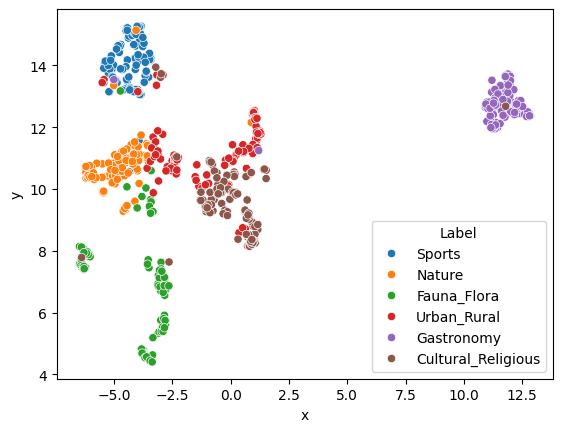

In [5]:
train_df['x'] = viz_train_reduced[:, 0]
train_df['y'] = viz_train_reduced[:, 1]
sns.scatterplot(
    train_df, x='x', y='y', 
    hue='Label', 
    palette=sns.color_palette("tab10", n_colors=6)
)

### For clustering

In [6]:
reducer = UMAP(n_neighbors=15, n_components=20, metric='cosine')
train_reduced = reducer.fit_transform(train_embeddings)
test_reduced = reducer.transform(test_embeddings)

## Clustering

### HDBSCAN

In [7]:
clusterer = HDBSCAN(min_cluster_size=20, metric='euclidean', cluster_selection_method='eom', prediction_data=True, approx_min_span_tree=False)
clusterer.fit(train_reduced)

HDBSCAN(approx_min_span_tree=False, min_cluster_size=20, prediction_data=True)

/tmp/ipykernel_17999/1165245163.py:2: UserWarning: The palette list has more values (10) than needed (9), which may not be intended.
  ax = sns.scatterplot(


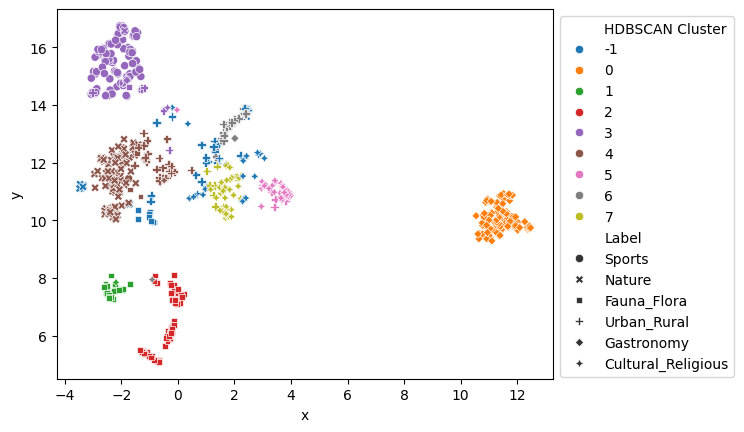

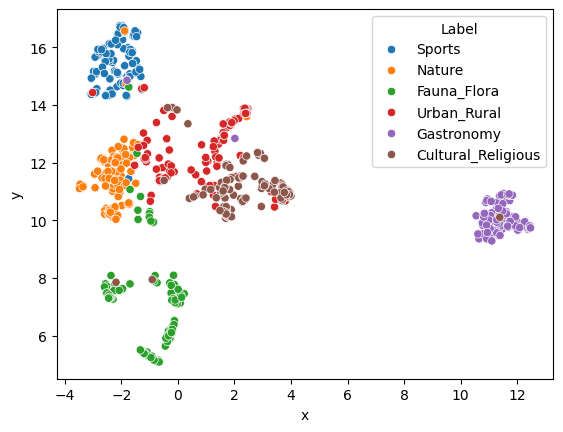

In [8]:
train_df['HDBSCAN Cluster'] = clusterer.labels_
ax = sns.scatterplot(
    train_df, x='x', y='y', hue='HDBSCAN Cluster', style='Label',
    palette=sns.color_palette("tab10", n_colors=10)
)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Position outside the plot
plt.show()

sns.scatterplot(
    train_df, x='x', y='y', hue='Label', 
    palette=sns.color_palette("tab10", n_colors=6)
)
plt.show()

<Axes: ylabel='$\\lambda$ value'>

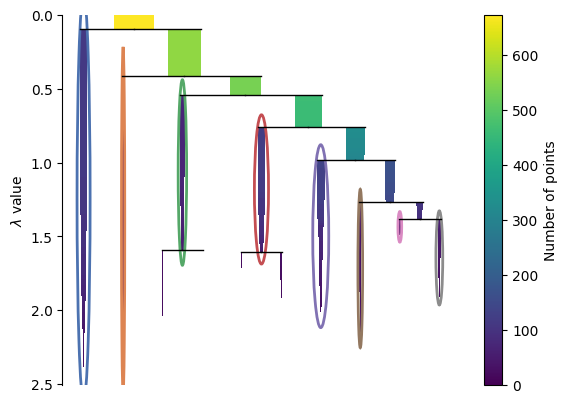

In [9]:
clusterer.condensed_tree_.plot(
    select_clusters=True,
    selection_palette=sns.color_palette('deep', 8)
)

### KMeans

In [7]:
kmeans_clusterer = AgglomerativeClustering(n_clusters=6)#, n_init=20, max_iter=10000)
kmeans_clusterer.fit(train_reduced)

AgglomerativeClustering(n_clusters=6)

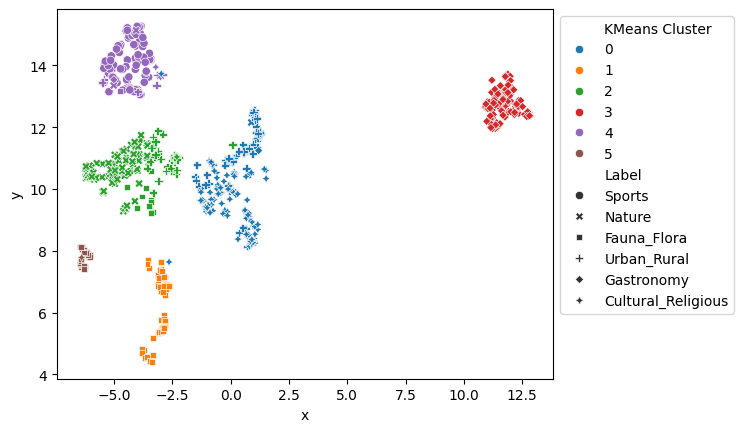

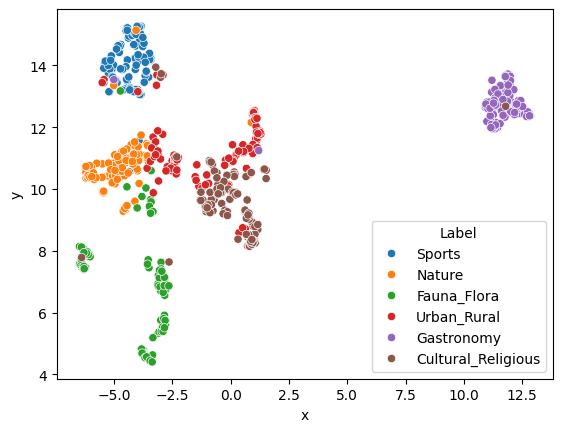

In [8]:
train_df['KMeans Cluster'] = kmeans_clusterer.labels_
ax=sns.scatterplot(
    train_df, x='x', y='y', hue='KMeans Cluster', style='Label',
    palette=sns.color_palette("tab10", n_colors=6)
)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Position outside the plot
plt.show()

sns.scatterplot(
    train_df, x='x', y='y', hue='Label', 
    palette=sns.color_palette("tab10", n_colors=6)
)
plt.show()

## Clusters BoW

Cluster 0


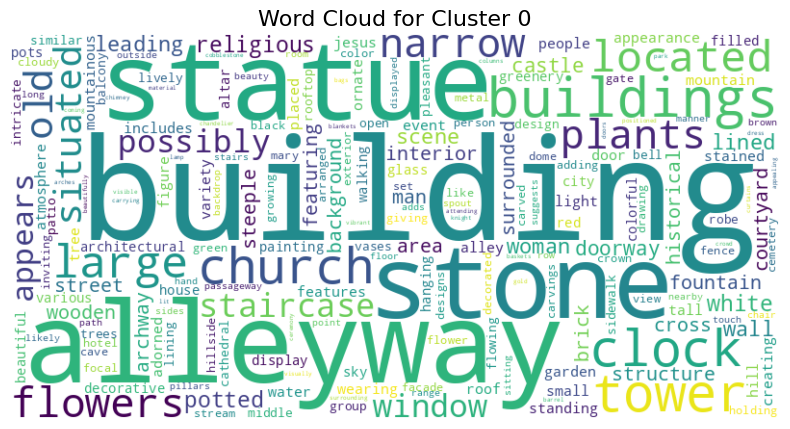

building: 0.4890
alleyway: 0.2905
statue: 0.2734
stone: 0.2332
buildings: 0.2289
tower: 0.2165
clock: 0.2051
church: 0.1893
large: 0.1618
located: 0.1459


Cluster 1


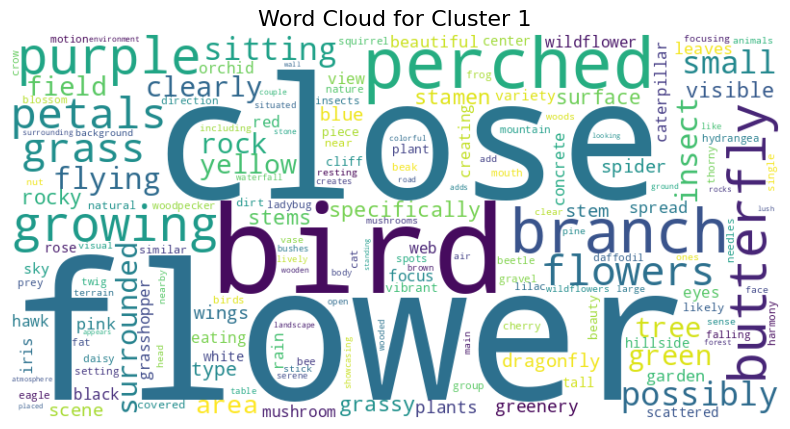

flower: 0.4588
close: 0.3621
bird: 0.3560
perched: 0.3221
branch: 0.2374
butterfly: 0.1695
purple: 0.1643
growing: 0.1526
petals: 0.1526
flowers: 0.1409


Cluster 2


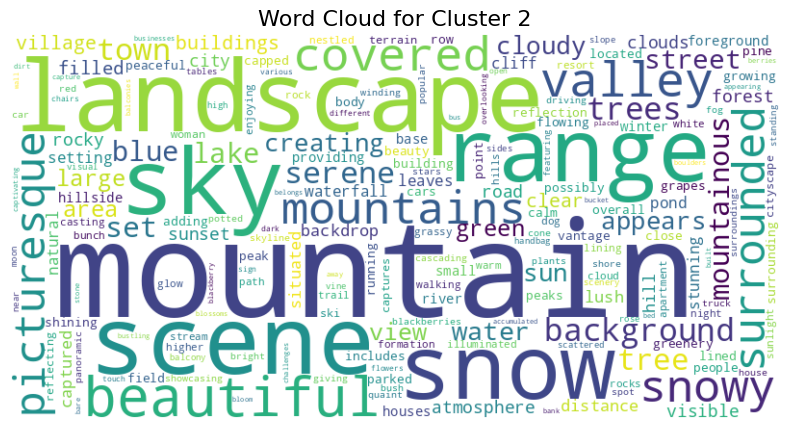

mountain: 0.5360
landscape: 0.2482
scene: 0.2322
sky: 0.2154
snow: 0.2130
range: 0.2045
beautiful: 0.2018
valley: 0.1514
covered: 0.1460
mountains: 0.1363


Cluster 3


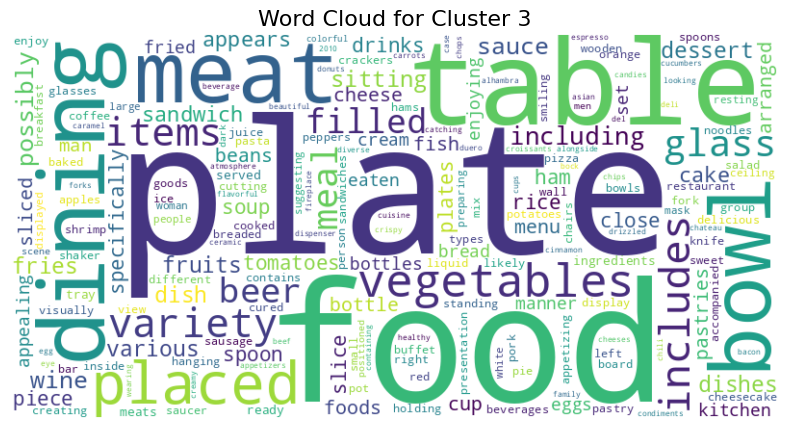

plate: 0.5810
food: 0.4547
table: 0.3760
dining: 0.2021
meat: 0.1768
bowl: 0.1705
placed: 0.1456
vegetables: 0.1453
includes: 0.1161
variety: 0.1124


Cluster 4


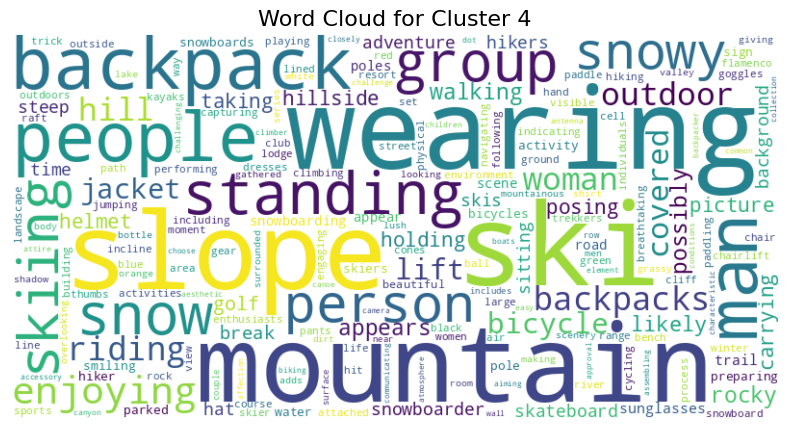

ski: 0.2948
wearing: 0.2860
slope: 0.2638
mountain: 0.2617
backpack: 0.2365
man: 0.2327
people: 0.2181
standing: 0.1890
snow: 0.1768
skiing: 0.1707


Cluster 5


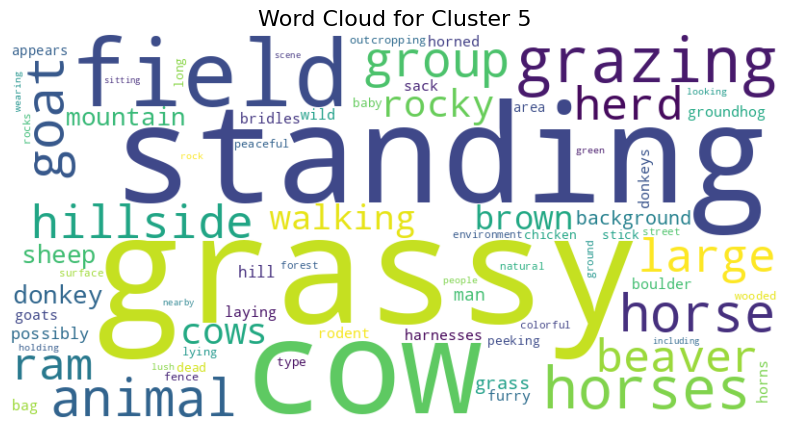

grassy: 0.4321
standing: 0.3435
cow: 0.3186
field: 0.3032
grazing: 0.2731
horses: 0.2276
animal: 0.1821
goat: 0.1821
horse: 0.1821
group: 0.1632




In [10]:
# Step 1: Combine all documents in the same cluster into a single document
clustered_docs = train_df.groupby('KMeans Cluster')['caption'].apply(' '.join).reset_index()
clustered_docs['caption'] = clustered_docs['caption'].str.replace('image', '')
clustered_docs['caption'] = clustered_docs['caption'].str.replace('shows', '')

# Step 2: Calculate the TF-IDF for the combined documents
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(clustered_docs['caption'])

# Step 3: Get the feature names (words)
feature_names = vectorizer.get_feature_names_out()

# Step 4: Extract the top 10 words with the highest TF-IDF score for each cluster
top_n = 10
clusters_words = {}
for idx, row in enumerate(tfidf_matrix):
    representative_words = []
    cluster = clustered_docs['KMeans Cluster'][idx]
    print(f"Cluster {cluster}")
    # Get the TF-IDF scores for the row and corresponding feature names
    tfidf_scores = zip(feature_names, row.toarray().flatten())
    # Convert to dictionary (word: tf-idf score)
    tfidf_dict = {word: score for word, score in tfidf_scores}
    # Generate the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(tfidf_dict)
    # Plot the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for Cluster {cluster}', fontsize=16)
    plt.show()
    # Sort by TF-IDF score in descending order and get the top N words
    tfidf_scores = zip(feature_names, row.toarray().flatten())
    sorted_scores = sorted(tfidf_scores, key=lambda x: x[1], reverse=True)[:top_n]
    for word, score in sorted_scores:
        representative_words.append(word)
        print(f"{word}: {score:.4f}")
    print("\n")
    clusters_words[cluster] = representative_words
    

## Zero-shot cluster classification

In [11]:
llama_model_id = 'google/flan-t5-large'
labels = ['Sports', 'Nature', 'Urban and rural', 'Flora and fauna', 'Gastronomy', 'Cultural and religious']

def generate_zero_shot_classification_prompt(words, labels):
    prompt = f"""Giveng the following keywords from a cluster, classify the cluster into one category.

Keywords: {', '.join(words)}

Categories: {', '.join(labels)}
"""
    return prompt

def classify_text(model, tokenizer, words, labels, max_length=150):
    prompt = generate_zero_shot_classification_prompt(words, labels)
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    outputs = model.generate(**inputs, max_length=max_length)

    # Decode the generated text
    category = tokenizer.decode(outputs[0], skip_special_tokens=True)
    # Extract the category from the generated text
    return category

In [12]:

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(llama_model_id)
model = AutoModelForSeq2SeqLM.from_pretrained(
    llama_model_id,
    load_in_4bit=True,
    device_map="auto",  # This automatically places the model on the available GPUs
    torch_dtype=torch.float16,  # You can use bfloat16 or float16 for better memory usage
)


The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


In [13]:

cluster_mapping = {}
for cluster, words in clusters_words.items():
    category = classify_text(model, tokenizer, words, labels)
    print(f"Words: {', '.join(words)}")
    print(f"Category: {category}")
    print("----------------------------")
    cluster_mapping[cluster] = category

    

/home/nacho/Documents/Master/TFM/code/venv/lib/python3.12/site-packages/bitsandbytes/nn/modules.py:426: UserWarning: Input type into Linear4bit is torch.float16, but bnb_4bit_compute_dtype=torch.float32 (default). This will lead to slow inference or training speed.
  warnings.warn(
/home/nacho/Documents/Master/TFM/code/venv/lib/python3.12/site-packages/bitsandbytes/nn/modules.py:421: UserWarning: Input type into Linear4bit is torch.float16, but bnb_4bit_compute_dtype=torch.float32 (default). This will lead to slow inference.
  warnings.warn(


Words: building, alleyway, statue, stone, buildings, tower, clock, church, large, located
Category: Urban and rural
----------------------------
Words: flower, close, bird, perched, branch, butterfly, purple, growing, petals, flowers
Category: Flora and fauna
----------------------------
Words: mountain, landscape, scene, sky, snow, range, beautiful, valley, covered, mountains
Category: Nature
----------------------------
Words: plate, food, table, dining, meat, bowl, placed, vegetables, includes, variety
Category: Gastronomy
----------------------------
Words: ski, wearing, slope, mountain, backpack, man, people, standing, snow, skiing
Category: Sports
----------------------------
Words: grassy, standing, cow, field, grazing, horses, animal, goat, horse, group
Category: Nature
----------------------------


In [14]:
train_df['zero_shot_label'] = train_df['KMeans Cluster'].map(cluster_mapping)
zslabels2id = {
    'Cultural and religious': 0,
    'Flora and fauna': 1,
    'Gastronomy': 2,
    'Nature': 3,
    'Sports': 4,
    'Urban and rural': 5 
}
train_df['zs_id'] = train_df['zero_shot_label'].map(zslabels2id)
y_true = train_df['label'].tolist()
y_pred = train_df['zs_id'].tolist()
#print(train_df[train_df['zs_id'].isna()])
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
acc = accuracy_score(y_true, y_pred)
print(f"Precision: {str(round(precision*100, 2))}")
print(f"Recall: {str(round(recall*100, 2))}")
print(f"Accuracy: {str(round(acc*100, 2))}")



Precision: 64.39
Recall: 70.09
Accuracy: 70.09


/home/nacho/Documents/Master/TFM/code/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


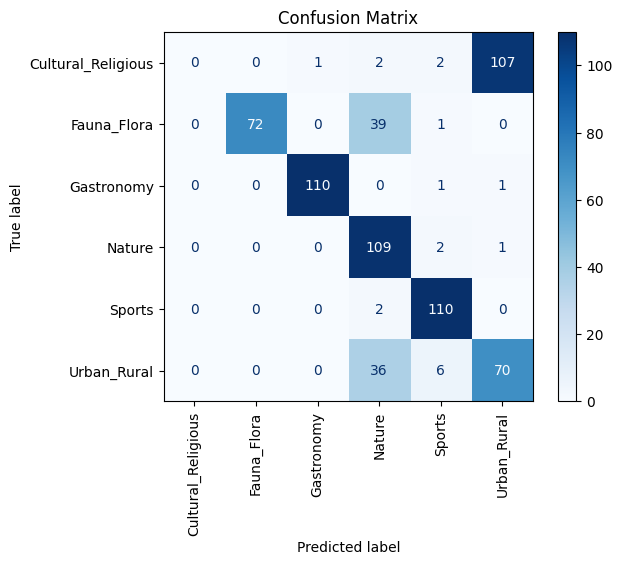

[0.         0.64285714 0.98214286 0.97321429 0.98214286 0.625     ]


In [15]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label2id.keys()))
# Plot the confusion matrix
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xticks(rotation=90)
plt.show()
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print(cm.diagonal())